In [1]:
import time
import sys, os
import pickle
import numpy as np
import scvelo as scv
import scanpy
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from veloproj import *
from veloproj.model import leastsq_pt
from IPython import display
from matplotlib import pyplot as plt
import anndata

In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr', '1e-6', 
                               '--n-epochs', '20000', 
                               '--g-rep-dim', '100',
                               '--k-dim', '100',
                               '--data-dir', '/data/users/cqiao/notebooks/data/organoids.h5ad',
                               '--model-name', 'baseline_tmp.cpt',
                               '--exp-name', 'baseline_scEU',
                               '--nb_g_src', "SU",
                               '--device', 'cuda:3'
                              ])

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [4]:
cluster_edges = [("3", "1"), ("3", "2")]
k_cluster = "monocle_branch_id"
EXP_NAME = args.exp_name
exp_metrics = {}

In [5]:
def main_AE(args, model, lr=args.lr, weight_decay=args.weight_decay, save_name="tmp.cpt"):
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    lr = args.lr  
    i, losses = 0, [sys.maxsize]  
    min_loss = losses[-1]
    model_saved = False

    model.train()
    while i < args.n_epochs:
        i += 1
        loss = train_step_AE([tensor_s, tensor_u], model, optimizer, xyids=[0, 1], device=device)
        losses.append(loss)
        if i % args.log_interval == 0:
            if losses[-1] < min_loss:
                min_loss = losses[-1]
                torch.save(model.state_dict(), os.path.join(args.output, save_name))
                model_saved = True
            else:
                if model_saved:
                    model.load_state_dict(torch.load(os.path.join(args.output, save_name)))
                    model = model.to(device)
                lr *= args.lr_decay
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr

            print("Train Epoch: {:2d}/{:2d} \tLoss: {:.6f}"
                  .format(i, args.n_epochs, losses[-1]))

    plt.plot(losses[1:])
    if losses[-1] < min_loss:
        torch.save(model.state_dict(), os.path.join(args.output, save_name))
    return model

In [6]:
adata = scanpy.read_h5ad(args.data_dir)
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
print(adata)

Abundance of ['spliced', 'unspliced']: [0.68 0.32]
Filtered out 3746 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:17) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
AnnData object with n_obs × n_vars = 3831 × 2000
    obs: 'well_id', 'batch_id', 'treatment_id', 'log10_gfp', 'som_cluster_id', 'monocle_branch_id', 'monocle_pseudotime', 'rotated_umap1', 'rotated_umap2', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'gene', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'pca', 'neighbors'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'conn

computing velocities
    finished (0:00:00) --> added 
    'stc_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:06) --> added 
    'stc_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'stc_velocity_length' (adata.obs)
--> added 'stc_velocity_confidence' (adata.obs)
--> added 'stc_velocity_confidence_transition' (adata.obs)
computing velocity embedding
    finished (0:00:01) --> added
    'stc_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_scEU_stochastical.png


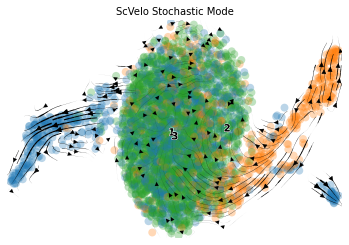

# Cross-Boundary Transition Score (A->B)
{('3', '1'): 0.15114777, ('3', '2'): 0.08071256}
Total Mean: 0.11593016237020493
# Cross-Boundary Velocity Coherence (A->B)
{('3', '1'): 0.79889697, ('3', '2'): 0.8207498}
Total Mean: 0.8098233938217163
# Cross-Boundary Direction Correctness (A->B)
{('3', '1'): 0.10821400009650162, ('3', '2'): 0.07437119337077965}
Total Mean: 0.09129259673364062
# In-cluster Coherence
{'1': 0.8049664, '2': 0.8545274, '3': 0.83366334}
Total Mean: 0.8310523629188538
# In-cluster Confidence
{'1': 0.7199635048156345, '2': 0.7906047247751308, '3': 0.7805492314829755}
Total Mean: 0.7637058203579136


In [7]:
scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
scv.tl.velocity_graph(adata, vkey='stc_velocity')
scv.tl.velocity_confidence(adata, vkey='stc_velocity')
scv.pl.velocity_embedding_stream(adata, vkey="stc_velocity", basis='X_umap', color=k_cluster,
                                title='ScVelo Stochastic Mode', save="scEU_stochastical.png")
exp_metrics['stc_mode'] = evaluate(adata, cluster_edges, k_cluster, "stc_velocity")

In [8]:
spliced = adata.layers['Ms']
unspliced = adata.layers['Mu']
tensor_s, tensor_u = torch.FloatTensor(spliced).to(device), torch.FloatTensor(unspliced).to(device)
tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

Train Epoch: 100/20000 	Loss: 0.971400
Train Epoch: 200/20000 	Loss: 0.957496
Train Epoch: 300/20000 	Loss: 0.946548
Train Epoch: 400/20000 	Loss: 0.938212
Train Epoch: 500/20000 	Loss: 0.932290
Train Epoch: 600/20000 	Loss: 0.927083
Train Epoch: 700/20000 	Loss: 0.923206
Train Epoch: 800/20000 	Loss: 0.919764
Train Epoch: 900/20000 	Loss: 0.916437
Train Epoch: 1000/20000 	Loss: 0.913729
Train Epoch: 1100/20000 	Loss: 0.910858
Train Epoch: 1200/20000 	Loss: 0.908217
Train Epoch: 1300/20000 	Loss: 0.905415
Train Epoch: 1400/20000 	Loss: 0.902470
Train Epoch: 1500/20000 	Loss: 0.899300
Train Epoch: 1600/20000 	Loss: 0.895833
Train Epoch: 1700/20000 	Loss: 0.892046
Train Epoch: 1800/20000 	Loss: 0.887872
Train Epoch: 1900/20000 	Loss: 0.883142
Train Epoch: 2000/20000 	Loss: 0.877854
Train Epoch: 2100/20000 	Loss: 0.872148
Train Epoch: 2200/20000 	Loss: 0.866009
Train Epoch: 2300/20000 	Loss: 0.859377
Train Epoch: 2400/20000 	Loss: 0.852367
Train Epoch: 2500/20000 	Loss: 0.845004
Train Epo

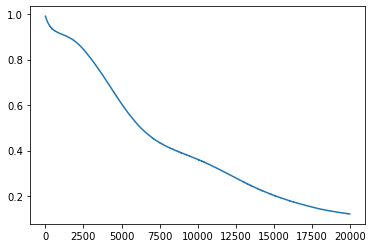

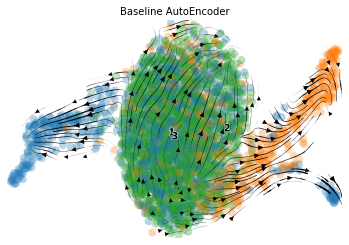

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('3', '1'): 0.123982675, ('3', '2'): 0.10531737}
Total Mean: 0.11465002596378326
# Cross-Boundary Velocity Coherence (A->B)
{('3', '1'): 0.9999599, ('3', '2'): 0.9999644}
Total Mean: 0.9999621510505676
# Cross-Boundary Direction Correctness (A->B)
{('3', '1'): -0.016872999123703592, ('3', '2'): 0.02619790789830013}
Total Mean: 0.00466245438729827
# In-cluster Coherence
{'1': 0.999964, '2': 0.9999737, '3': 0.99996674}
Total Mean: 0.9999682307243347
# In-cluster Confidence
{'1': 0.9999525475482277, '2': 0.9999636813244657, '3': 0.9999617783584405}
Total Mean: 0.9999593357437112


In [9]:
def expBaseAE(adata, exp_metrics):
    n_cells, n_genes = adata.X.shape
    in_dim = n_genes
    z_dim = args.z_dim
    h_dim = args.h_dim
    
    model = get_baseline_AE(in_dim, z_dim, h_dim).to(device)
    model = main_AE(args, model, save_name=f"baseAE_{args.model_name}")
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        _, gamma, _ = leastsq_pt(s, u, 
                                    device=device, 
                                    fit_offset=True, 
                                    perc=[5, 95]
                                    )
        v = (u - gamma * s).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
        
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Baseline AutoEncoder",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Baseline AutoEncoder'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expBaseAE(adata, exp_metrics)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Train Epoch: 100/20000 	Loss: 0.914360
Train Epoch: 200/20000 	Loss: 0.913268
Train Epoch: 300/20000 	Loss: 0.912195
Train Epoch: 400/20000 	Loss: 0.911094
Train Epoch: 500/20000 	Loss: 0.909918
Train Epoch: 600/20000 	Loss: 0.908619
Train Epoch: 700/20000 	Loss: 0.907140
Train Epoch: 800/20000 	Loss: 0.905412
Train Epoch: 900/20000 	Loss: 0.903365
Train Epoch: 1000/20000 	Loss: 0.900966
Train Epoch: 1100/20000 	Loss: 0.898236
Train Epoch: 1200/20000 	Loss: 0.895259
Train Epoch: 1300/20000 	Loss: 0.892114
Train Epoch: 1400/20000 	Loss: 0.888856
Train Epoch: 1500/20000 	Loss: 0.885499
Train Epoch: 1600/20000 	Loss: 0.882036
Train Epoch: 1700/20000 	Loss: 0.878455
Train Epoch: 1800/20000 	Loss: 0.874751
Train Epoch: 

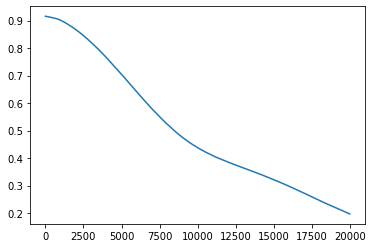

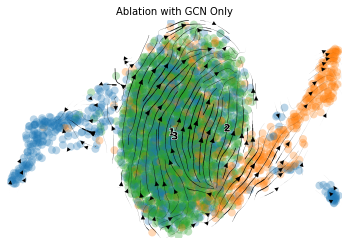

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('3', '1'): 0.13479915, ('3', '2'): 0.069225684}
Total Mean: 0.10201241821050644
# Cross-Boundary Velocity Coherence (A->B)
{('3', '1'): 0.99999225, ('3', '2'): 0.99999255}
Total Mean: 0.9999923706054688
# Cross-Boundary Direction Correctness (A->B)
{('3', '1'): 0.017159540836887373, ('3', '2'): 0.028013952738497543}
Total Mean: 0.022586746787692458
# In-cluster Coherence
{'1': 0.9999939, '2': 0.99999464, '3': 0.9999932}
Total Mean: 0.9999939799308777
# In-cluster Confidence
{'1': 0.9999926187443418, '2': 0.9999933535473188, '3': 0.9999929246024706}
Total Mean: 0.999992965631377


In [10]:
def expAblationCohAgg(adata, exp_metrics):
    n_cells, n_genes = adata.X.shape
    in_dim = n_genes
    z_dim = args.z_dim
    h_dim = args.h_dim
    g_basis = args.nb_g_src
    model = get_ablation_CohAgg(
                                adata,
                                in_dim,
                                z_dim,
                                h_dim,
                                g_basis,
                                device)
    model = main_AE(args, model, save_name=f"CohAgg_{args.model_name}")
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        _, gamma, _ = leastsq_pt(s, u, 
                                    device=device, 
                                    fit_offset=True, 
                                    perc=[5, 95]
                                    )
        v = (u - gamma * s).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
        
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Ablation with GCN Only",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Ablation GCN Only'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expAblationCohAgg(adata, exp_metrics)

Train Epoch: 100/20000 	Loss: 0.954313
Train Epoch: 200/20000 	Loss: 0.940779
Train Epoch: 300/20000 	Loss: 0.917190
Train Epoch: 400/20000 	Loss: 0.887206
Train Epoch: 500/20000 	Loss: 0.853468
Train Epoch: 600/20000 	Loss: 0.823576
Train Epoch: 700/20000 	Loss: 0.798804
Train Epoch: 800/20000 	Loss: 0.779551
Train Epoch: 900/20000 	Loss: 0.763536
Train Epoch: 1000/20000 	Loss: 0.748516
Train Epoch: 1100/20000 	Loss: 0.738442
Train Epoch: 1200/20000 	Loss: 0.726864
Train Epoch: 1300/20000 	Loss: 0.714713
Train Epoch: 1400/20000 	Loss: 0.708043
Train Epoch: 1500/20000 	Loss: 0.696464
Train Epoch: 1600/20000 	Loss: 0.681914
Train Epoch: 1700/20000 	Loss: 0.676502
Train Epoch: 1800/20000 	Loss: 0.667485
Train Epoch: 1900/20000 	Loss: 0.658559
Train Epoch: 2000/20000 	Loss: 0.652830
Train Epoch: 2100/20000 	Loss: 0.646471
Train Epoch: 2200/20000 	Loss: 0.640060
Train Epoch: 2300/20000 	Loss: 0.638414
Train Epoch: 2400/20000 	Loss: 0.634429
Train Epoch: 2500/20000 	Loss: 0.627277
Train Epo

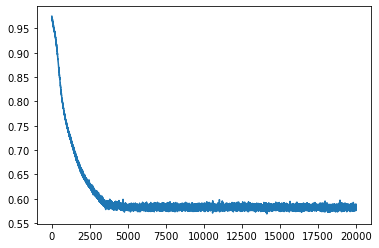

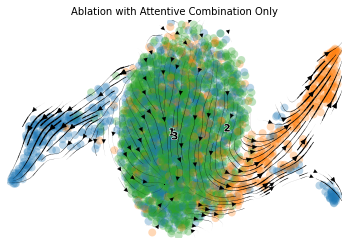

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('3', '1'): 0.17381497, ('3', '2'): 0.18039614}
Total Mean: 0.17710554599761963
# Cross-Boundary Velocity Coherence (A->B)
{('3', '1'): 0.99824715, ('3', '2'): 0.9983711}
Total Mean: 0.9983091354370117
# Cross-Boundary Direction Correctness (A->B)
{('3', '1'): 0.1525688507669513, ('3', '2'): 0.17162405278109633}
Total Mean: 0.16209645177402382
# In-cluster Coherence
{'1': 0.9984131, '2': 0.99842024, '3': 0.99850863}
Total Mean: 0.9984473586082458
# In-cluster Confidence
{'1': 0.9980910549199344, '2': 0.9980930525560363, '3': 0.9984027867590017}
Total Mean: 0.9981956314116575


In [11]:
def expAblationAttComb(adata, exp_metrics):
    from sklearn.decomposition import PCA
    n_cells, n_genes = adata.X.shape
    z_dim = args.z_dim
    g_rep_dim = args.g_rep_dim
    h_dim = args.h_dim
    k_dim = args.k_dim
    gb_tau = args.gumbsoft_tau
    G_embeddings = PCA(n_components=g_rep_dim).fit_transform(adata.X.T.toarray())
    
    model = get_ablation_attcomb(
        z_dim,
        n_genes,
        n_cells,
        h_dim,
        k_dim,
        G_embeddings,
        g_rep_dim,
        gb_tau,
        device)
    
            
    model = main_AE(args, model, save_name=f"AttComb_{args.model_name}")
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        _, gamma, _ = leastsq_pt(s, u, 
                                    device=device, 
                                    fit_offset=True, 
                                    perc=[5, 95]
                                    )
        v = (u - gamma * s).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Ablation with Attentive Combination Only",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Ablation AttComb Only'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expAblationAttComb(adata, exp_metrics)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)


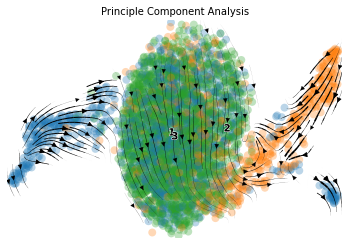

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('3', '1'): 0.08778177, ('3', '2'): 0.10249317}
Total Mean: 0.09513746947050095
# Cross-Boundary Velocity Coherence (A->B)
{('3', '1'): 0.97700965, ('3', '2'): 0.97856486}
Total Mean: 0.9777872562408447
# Cross-Boundary Direction Correctness (A->B)
{('3', '1'): 0.03357532695878986, ('3', '2'): 0.01535581917900892}
Total Mean: 0.02446557306889939
# In-cluster Coherence
{'1': 0.96938866, '2': 0.91278344, '3': 0.9810876}
Total Mean: 0.9544199109077454
# In-cluster Confidence
{'1': 0.9632211959618606, '2': 0.9021946781635479, '3': 0.9802424441819167}
Total Mean: 0.9485527727691084


In [12]:
def expPCA(adata, exp_metrics):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=args.z_dim)
    x, s, u, v = sklearn_decompose(pca, 
                                   tensor_x.detach().cpu().numpy(), 
                                   tensor_s.detach().cpu().numpy(), 
                                   tensor_u.detach().cpu().numpy(), 
                                   tensor_v.detach().cpu().numpy()
                                  )
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Principle Component Analysis",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Baseline PCA'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expPCA(adata, exp_metrics)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:02) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)


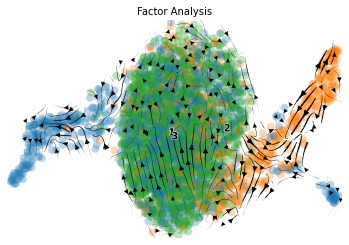

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('3', '1'): 0.13897128, ('3', '2'): 0.13904896}
Total Mean: 0.13901013135910034
# Cross-Boundary Velocity Coherence (A->B)
{('3', '1'): 0.5522016006293204, ('3', '2'): 0.5429795930707885}
Total Mean: 0.5475905968500545
# Cross-Boundary Direction Correctness (A->B)
{('3', '1'): -0.004895345871635992, ('3', '2'): -0.08050380000924066}
Total Mean: -0.04269957294043833
# In-cluster Coherence
{'1': 0.6052316392716396, '2': 0.5749397415555683, '3': 0.5513584770331532}
Total Mean: 0.577176619286787
# In-cluster Confidence
{'1': 0.5262412825496895, '2': 0.5116535829990515, '3': 0.5486150697408548}
Total Mean: 0.5288366450965319


In [13]:
def expFA(adata, exp_metrics):
    from sklearn.decomposition import FactorAnalysis
    method = FactorAnalysis(n_components=args.z_dim)
    x, s, u, v = sklearn_decompose(method,
                                   tensor_x.detach().cpu().numpy(), 
                                   tensor_s.detach().cpu().numpy(), 
                                   tensor_u.detach().cpu().numpy(), 
                                   tensor_v.detach().cpu().numpy()
                                  )
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Factor Analysis",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Baseline FA'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expFA(adata, exp_metrics)

In [14]:
with open("{}.pkl".format(EXP_NAME), 'wb') as out_file:
    pickle.dump(exp_metrics, out_file)